In [2]:
# これは落書き帳

In [1]:
import dask.dataframe as dd
import pandas as pd

In [65]:
qry = """
select url, string_agg(concat(cast(index as string), ":",cast(cnt as string)), "\t") as bow from `masuda_partial_data.tmp_url2bow` group by url
"""

In [67]:
url2bow = pd.read_gbq(qry, dialect='standard')

Downloading: 100%|██████████| 32461/32461 [00:04<00:00, 8100.35rows/s]


In [68]:
url2bow.head()

,url,bow
0,https://ad.dmm.com/ad/p/r?_site=10708&_article...,0:1\t4103:1\t20:1\t101:1\t370:1\t915:1\t3020:1...
1,https://ad.dmm.com/ad/p/r?_site=10707&_article...,0:1\t4103:1\t20:1\t101:1\t370:1\t915:1\t3020:1...
2,https://ad.dmm.com/ad/p/r?_site=10708&_article...,0:1\t4103:1\t20:1\t101:1\t370:1\t915:1\t3020:1...
3,https://ad.dmm.com/ad/p/r?_site=10707&_article...,0:1\t4103:1\t20:1\t101:1\t370:1\t915:1\t3020:1...
4,https://ad.dmm.com/ad/p/r?_site=10708&_article...,0:1\t1119:1\t9057:1\t9058:1\t4982:1\t422:1\t29...


In [69]:
corpus = []
url2bow_list = list(url2bow["bow"])
for row in url2bow_list:
    bow_list = []
    for b in row.split():
        index, freq = b.split(":")
        bow_list.append((int(index), int(freq)))
    corpus.append(bow_list)

In [70]:
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [71]:
from gensim.models.ldamodel import LdaModel
lda = LdaModel(corpus_tfidf, num_topics=8)

In [72]:
lda.save("lda_tfidf.model")

In [74]:
from gensim.corpora import Dictionary
dictionary = Dictionary.load_from_text("./common_dict.txt")

In [75]:
from tqdm import tqdm
import gensim
import numpy as np
#Metrics for Topic Models
start = 2
limit = 22
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus_tfidf)))
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus,dictionary=dictionary, coherence='u_mass')
    coherence_vals.append(coherence_model_lda.get_coherence())


  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()

# save as png
plt.savefig('metrics.png') 

In [82]:
common_dict = {}
with open("common_dict.txt", "r") as f:
    for l in f.readlines():
        index, word, _ = l.strip().split()
        common_dict[index] = word


In [83]:
def index2word(dic):
    res = {}
    for k, v in dic.items():
        res[common_dict[k]] = v
    return res

In [84]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import math

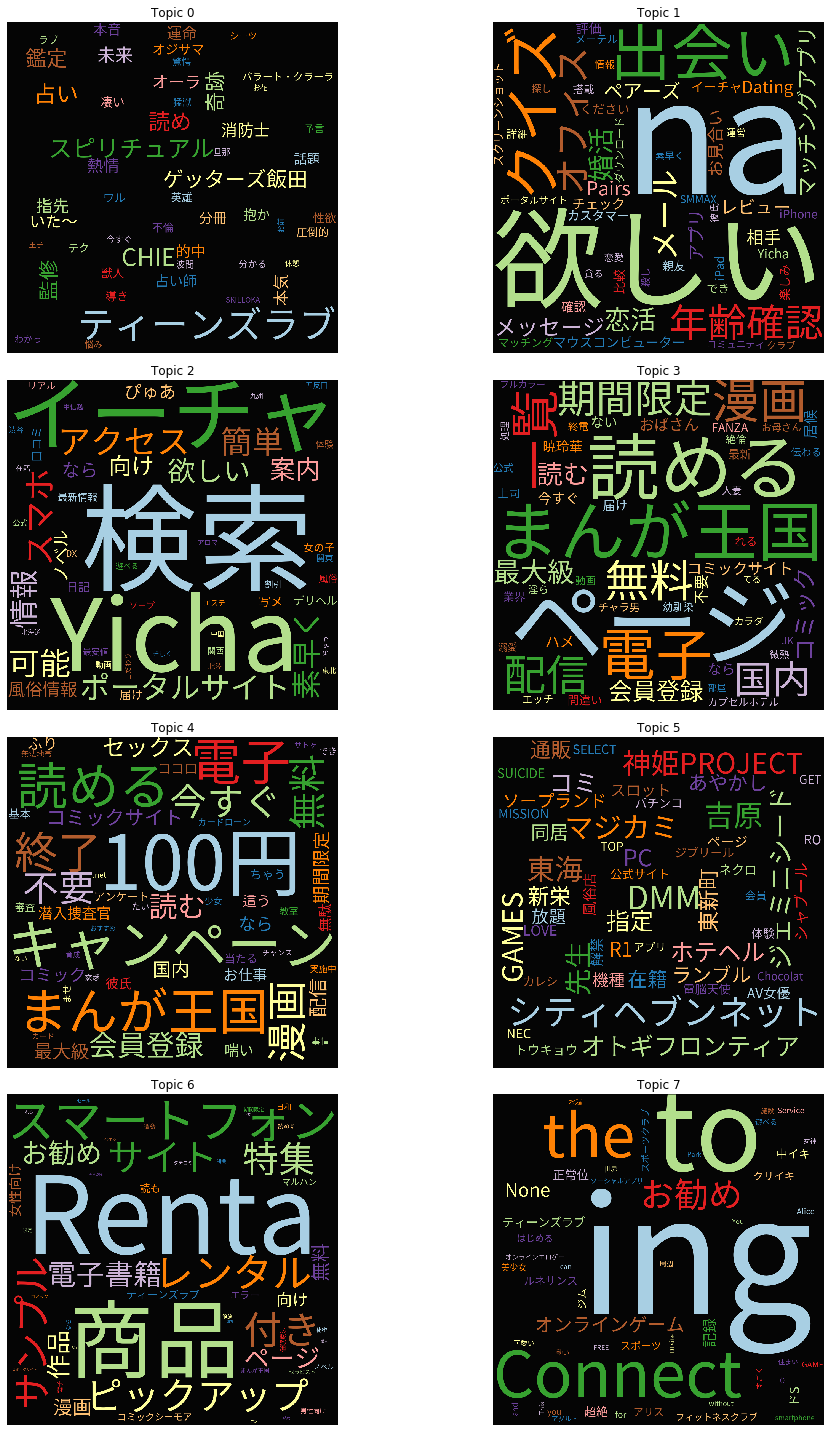

In [85]:
fig, axs = plt.subplots(ncols=2, nrows=math.ceil(lda.num_topics / 2), figsize=(16,20))
axs = axs.flatten()
def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda.num_topics)):
    x = index2word(dict(lda.show_topic(t, 50)))
    fpath = "/Users/wataru-masuda/.font/NotoSansCJKjp-Regular.otf"
    im = WordCloud(
        color_func=color_func,
        font_path=fpath,
        max_words=4000,
        width=1200, height=1200,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))
    
plt.tight_layout()
plt.savefig("wordcloud_each_topics.png")

In [112]:
url2doc_topics = []
for i, row in url2bow.iterrows():
    try:
        bow = [(tmp.split(":")[0], tmp.split(":")[1]) for tmp in str(row.bow).split()]
        doc_topics = lda.get_document_topics(bow, minimum_probability=1e-30)
        row = []
        #print(url, doc_topics)
        for col_tuple in doc_topics:
            #print(col_tuple)
            row.append(col_tuple[1])
        url2doc_topics.append(row)
        #print(row)    
    except:
        pass


In [113]:
url2doc_topics_df = pd.DataFrame(url2doc_topics)

In [119]:
url2doc_topics_df.head()

,url,1,2,3,4,5,6,7,8
0,https://ad.dmm.com/ad/p/r?_site=10708&_article...,0.008362,0.008358,0.008358,0.941462,0.008358,0.008377,0.008358,0.008367
1,https://ad.dmm.com/ad/p/r?_site=10707&_article...,0.008362,0.008358,0.008358,0.941462,0.008358,0.008377,0.008358,0.008367
2,https://ad.dmm.com/ad/p/r?_site=10708&_article...,0.008362,0.008358,0.008358,0.941462,0.008358,0.008377,0.008358,0.008367
3,https://ad.dmm.com/ad/p/r?_site=10707&_article...,0.008362,0.008358,0.008358,0.941462,0.008358,0.008378,0.008358,0.008367
4,https://ad.dmm.com/ad/p/r?_site=10708&_article...,0.508200,0.013452,0.013448,0.257359,0.013457,0.013450,0.167142,0.013492


In [118]:
url2doc_topics_df = url2doc_topics_df.rename(columns={0:"url"})

In [120]:
url2doc_topics_df = url2doc_topics_df.set_index("url")

In [122]:
url2doc_topics_df.shape

(29516, 8)

In [129]:
url2doc_topics_df.head()

,1,2,3,4,5,6,7,8
url,,,,,,,,
https://ad.dmm.com/ad/p/r?_site=10708&_article=14393&_link=494950&_image=495048&suid={gsclickid},0.008362,0.008358,0.008358,0.941462,0.008358,0.008377,0.008358,0.008367
https://ad.dmm.com/ad/p/r?_site=10707&_article=14392&_link=494924&_image=495022&suid={gsclickid},0.008362,0.008358,0.008358,0.941462,0.008358,0.008377,0.008358,0.008367
https://ad.dmm.com/ad/p/r?_site=10708&_article=14393&_link=494963&_image=495061&suid={gsclickid},0.008362,0.008358,0.008358,0.941462,0.008358,0.008377,0.008358,0.008367
https://ad.dmm.com/ad/p/r?_site=10707&_article=14392&_link=494937&_image=495035&suid={gsclickid},0.008362,0.008358,0.008358,0.941462,0.008358,0.008378,0.008358,0.008367
https://ad.dmm.com/ad/p/r?_site=10708&_article=14393&_link=511392&_image=511491&suid={gsclickid},0.508200,0.013452,0.013448,0.257359,0.013457,0.013450,0.167142,0.013492


In [117]:
from sklearn.manifold import TSNE


In [123]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(url2doc_topics_df)

In [124]:
X_reduced.shape

(29516, 2)

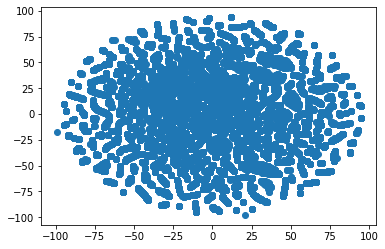

In [125]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

In [126]:
from sklearn.decomposition import PCA

X_reduced_pca = PCA(n_components=2).fit_transform(url2doc_topics_df)

In [127]:
X_reduced_pca.shape

(29516, 2)

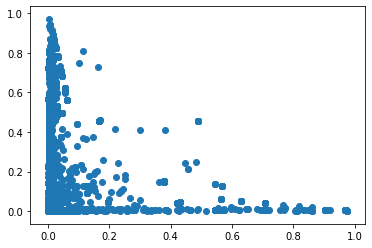

In [137]:
plt.scatter(url2doc_topics_df[2], url2doc_topics_df[6])


In [138]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
vis

/Users/wataru-masuda/.virtualenvs/python3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.129862  0.007249       1        1   3.988196
1      0.139448 -0.010899       2        1  14.422563
2     -0.007574 -0.101776       3        1   8.157777
3      0.029619  0.156098       4        1  35.846348
4      0.082309  0.107808       5        1  18.542088
5      0.136340 -0.000146       6        1   4.640627
6     -0.362715  0.171710       7        1   8.523346
7     -0.147290 -0.330044       8        1   5.879052, topic_info=      Category          Freq        Term         Total  loglift  logprob
3670   Default  16684.000000         ing  16684.000000  30.0000  30.0000
4859   Default  16321.000000          to  16321.000000  29.0000  29.0000
1002   Default  15511.000000     Connect  15511.000000  28.0000  28.0000
4797   Default  13782.000000         the  13782.000000  27.0000  27.0000
2264   Default  13007.000000       Renta  13007.000000  26.0000  26.0000
4106   Default  14721.000000          na  14721.000000  25.0000  25.0000
16317  Default   9731.000000          検索   9731.000000  24.0000  24.0000
10149  Default  21439.000000         ページ  21439.000000  23.0000  23.0000
2823   Default   9193.000000       Yicha   9193.000000  22.0000  22.0000
7408   Default   9193.000000        イーチャ   9193.000000  21.0000  21.0000
16421  Default  13858.000000         欲しい  13858.000000  20.0000  20.0000
13111  Default   7927.000000          商品   7927.000000  19.0000  19.0000
8728   Default   7276.000000     スマートフォン   7276.000000  18.0000  18.0000
10878  Default   6672.000000        レンタル   6672.000000  17.0000  17.0000
8397   Default   6314.000000        サンプル   6314.000000  16.0000  16.0000
11641  Default   6317.000000          付き   6317.000000  15.0000  15.0000
9802   Default   6569.000000      ピックアップ   6569.000000  14.0000  14.0000
33     Default   9030.000000        100円   9030.000000  13.0000  13.0000
7939   Default   9016.000000      キャンペーン   9016.000000  12.0000  12.0000
8317   Default   6181.000000         サイト   6181.000000  11.0000  11.0000
17251  Default   6012.000000          特集   6012.000000  10.0000  10.0000
20403  Default   6096.000000        電子書籍   6096.000000   9.0000   9.0000
7112   Default   5446.000000        アクセス   5446.000000   8.0000   8.0000
5615   Default   6986.000000         お勧め   6986.000000   7.0000   7.0000
8717   Default   5819.000000         スマホ   5819.000000   6.0000   6.0000
11864  Default   5727.000000          作品   5727.000000   5.0000   5.0000
18221  Default   4907.000000          簡単   4907.000000   4.0000   4.0000
12893  Default   5093.000000          可能   5093.000000   3.0000   3.0000
9040   Default   4174.000000     ティーンズラブ   4174.000000   2.0000   2.0000
18276  Default   4607.000000         素早く   4607.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
19282   Topic8     93.346764          記録    114.509964   2.6294  -6.7224
16449   Topic8     63.212494         正常位     84.480965   2.5438  -7.1122
19589   Topic8     58.895481          超絶     79.928810   2.5284  -7.1830
9239    Topic8     65.959549          ドS     90.515129   2.5173  -7.0697
11313   Topic8     52.181240         中イキ     73.038467   2.4975  -7.3040
10817   Topic8     46.250130       ルネサンス     67.236061   2.4596  -7.4247
8541    Topic8     43.460960          ジム     64.596191   2.4375  -7.4869
7239    Topic8     40.751240         アリス     61.417198   2.4236  -7.5512
8711    Topic8     40.101303        スポーツ     60.941216   2.4153  -7.5673
8712    Topic8     31.978512     スポーツクラブ     52.754578   2.3332  -7.7937
9863    Topic8     30.302835   フィットネスクラブ     51.079945   2.3116  -7.8475
6522    Topic8     31.021313        はじめる     52.492950   2.3078  -7.8241
8035    Topic8     44.254585        クリイキ     75.298279   2.3023  -7.4688
3471    Topic8     27.975714         for     49.073792   2.2718  -7.9274
2412    Topic8     22.153107     Service     43.196777   2.

In [140]:
vis_tsne = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds="tsne", sort_topics=False)
vis_tsne

/Users/wataru-masuda/.virtualenvs/python3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
0       92.489578  30.399597       1        1   3.985708
1      -12.947049  39.832195       2        1  14.422351
2        1.319761 -65.057579       3        1   8.157653
3       36.009872  -6.924389       4        1  35.846390
4      100.403656 -27.810078       5        1  18.544136
5       42.042881  60.501106       6        1   4.640679
6      -31.067616 -16.048700       7        1   8.523554
7       59.831661 -70.292053       8        1   5.879535, topic_info=      Category          Freq        Term         Total  loglift  logprob
3670   Default  16685.000000         ing  16685.000000  30.0000  30.0000
4859   Default  16322.000000          to  16322.000000  29.0000  29.0000
1002   Default  15513.000000     Connect  15513.000000  28.0000  28.0000
4797   Default  13783.000000         the  13783.000000  27.0000  27.0000
2264   Default  13008.000000       Renta  13008.000000  26.0000  26.0000
4106   Default  14721.000000          na  14721.000000  25.0000  25.0000
16317  Default   9731.000000          検索   9731.000000  24.0000  24.0000
10149  Default  21440.000000         ページ  21440.000000  23.0000  23.0000
2823   Default   9193.000000       Yicha   9193.000000  22.0000  22.0000
7408   Default   9193.000000        イーチャ   9193.000000  21.0000  21.0000
16421  Default  13858.000000         欲しい  13858.000000  20.0000  20.0000
13111  Default   7927.000000          商品   7927.000000  19.0000  19.0000
8728   Default   7277.000000     スマートフォン   7277.000000  18.0000  18.0000
10878  Default   6672.000000        レンタル   6672.000000  17.0000  17.0000
8397   Default   6314.000000        サンプル   6314.000000  16.0000  16.0000
11641  Default   6317.000000          付き   6317.000000  15.0000  15.0000
9802   Default   6569.000000      ピックアップ   6569.000000  14.0000  14.0000
33     Default   9031.000000        100円   9031.000000  13.0000  13.0000
7939   Default   9017.000000      キャンペーン   9017.000000  12.0000  12.0000
8317   Default   6181.000000         サイト   6181.000000  11.0000  11.0000
17251  Default   6013.000000          特集   6013.000000  10.0000  10.0000
20403  Default   6096.000000        電子書籍   6096.000000   9.0000   9.0000
7112   Default   5446.000000        アクセス   5446.000000   8.0000   8.0000
5615   Default   6986.000000         お勧め   6986.000000   7.0000   7.0000
8717   Default   5819.000000         スマホ   5819.000000   6.0000   6.0000
11864  Default   5727.000000          作品   5727.000000   5.0000   5.0000
18221  Default   4907.000000          簡単   4907.000000   4.0000   4.0000
12893  Default   5093.000000          可能   5093.000000   3.0000   3.0000
9040   Default   4172.000000     ティーンズラブ   4172.000000   2.0000   2.0000
18276  Default   4607.000000         素早く   4607.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
19282   Topic8     93.354477          記録    114.517303   2.6294  -6.7224
16449   Topic8     63.217716         正常位     84.485802   2.5437  -7.1122
19589   Topic8     58.900345          超絶     79.933289   2.5283  -7.1830
9239    Topic8     65.964996          ドS     90.520493   2.5172  -7.0697
11313   Topic8     52.185551         中イキ     73.042404   2.4975  -7.3040
10817   Topic8     46.253952       ルネサンス     67.239487   2.4596  -7.4247
8541    Topic8     43.464554          ジム     64.599380   2.4374  -7.4869
7239    Topic8     40.754608         アリス     61.420181   2.4235  -7.5512
8711    Topic8     40.104614        スポーツ     60.944138   2.4152  -7.5673
8712    Topic8     31.981153     スポーツクラブ     52.756832   2.3331  -7.7937
9863    Topic8     30.305338   フィットネスクラブ     51.082058   2.3116  -7.8475
6522    Topic8     31.023876        はじめる     52.495056   2.3077  -7.8241
8035    Topic8     44.258240        クリイキ     75.302635   2.3022  -7.4688
3471    Topic8     27.978025         for     49.075714   2.2717  -7.9274
2412    Topic8     22.154938 

In [141]:
pyLDAvis.save_html(vis_tsne, 'pyldavis_output_tsne.html')
